In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image


# EDA

### Initial look

In [2]:
# load and take a look at dataset with masks information
df = pd.read_csv('../data/train_ship_segmentations_v2.csv')
df.shape

(231723, 2)

In [3]:
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


### Extracting new features and Data exploration

In [4]:
# create new column 'withShips' to indicate which rows have RLE mask
df['WithShips'] = df['EncodedPixels'].apply(lambda row: 0 if pd.isna(row) else 1)

In [5]:
# check amount of rows with RLE info
df['WithShips'].value_counts()

0    150000
1     81723
Name: WithShips, dtype: int64

Dataset contains 150k rows without RLE data and 81k with

Let's check for duplicates

In [6]:
df[df.duplicated(subset="ImageId")]

,ImageId,EncodedPixels,WithShips
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,1
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...,1
10,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,1
...,...,...,...
231656,ffea9a5ba.jpg,26797 1 27564 4 28332 5 29099 5 29866 5 30635 ...,1
231657,ffea9a5ba.jpg,544712 3 545476 7 546239 12 547002 17 547766 2...,1
231670,ffef7c3f3.jpg,119822 1 120589 3 121356 5 122123 7 122890 9 1...,1
231671,ffef7c3f3.jpg,476372 3 477138 5 477906 6 478674 6 479443 5 4...,1


CSV file contains 39k duplicated rows, we can find amount of ships on each picture using this information

In [7]:
# group original dataframe by ImageId and sum WithShips column
grouped_df = df.groupby(['ImageId']).agg({'WithShips': 'sum'}).reset_index()

In [8]:
# check shape
grouped_df.shape

(192556, 2)

In [9]:
grouped_df.head()

,ImageId,WithShips
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0


In [10]:
# rename column from WithShips to AmountShips
grouped_df.rename(columns={'WithShips': 'AmountShips'}, inplace=True)

Lets see how many pictures have certain amount of ships on them

In [11]:
grouped_df['AmountShips'].value_counts()

0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: AmountShips, dtype: int64

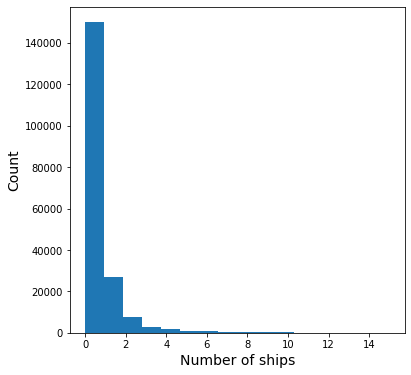

In [12]:
# plot a histogram
figure = plt.figure(figsize=(6, 6))
plt.hist(grouped_df['AmountShips'], bins = 16)
plt.xlabel('Number of ships', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

### Show random image with 7 boats and check its mask

In [13]:
num_ships = 7

ImageId = grouped_df['ImageId'].loc[grouped_df['AmountShips'] == num_ships].values[0]
print(ImageId)

00113a75c.jpg


In [14]:
# find image and open it
img = Image.open(f'../data/train_v2/{ImageId}')

# Extract RLE information from original dataframe using ImageId into list
masks = list(df['EncodedPixels'].loc[df['ImageId'] == ImageId])

#check that length of array equals to desired ships output
print(len(masks))

7


In [15]:
# define RLE decode function
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if not isinstance(mask_rle, str):
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        return img.reshape(shape).T

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [16]:
# create empty background mask
final_mask = np.zeros((768, 768))
#iterate through masks array, decode each RLE string and add to final_mask
for mask in masks:
    final_mask += rle_decode(mask)

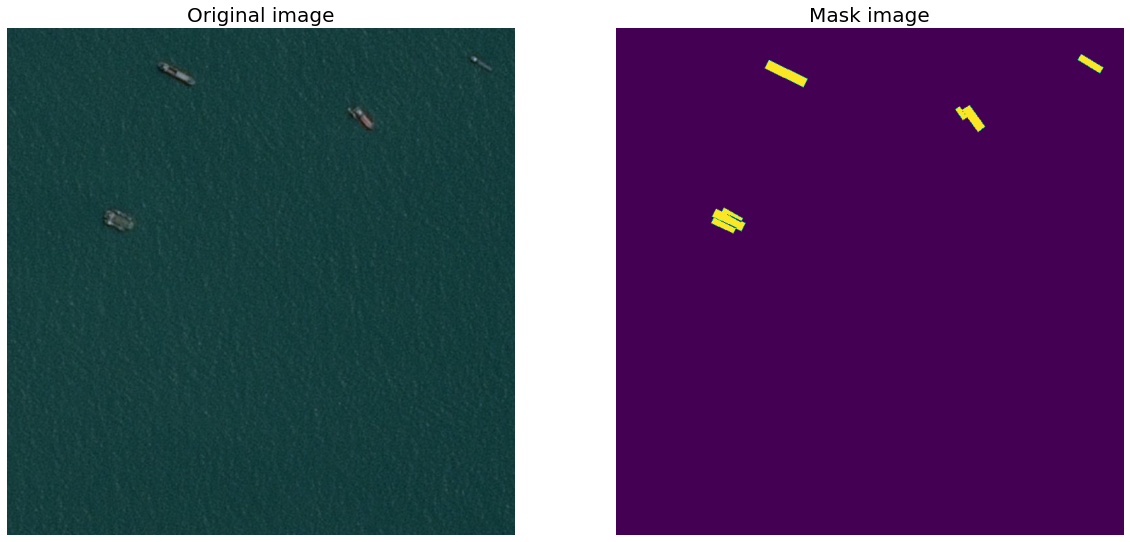

In [17]:
fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(20, 20))
ax1.axis('off')
ax1.imshow(img)
ax1.set_title('Original image', fontsize=20)

ax2.axis('off')
ax2.imshow(final_mask)
ax2.set_title('Mask image', fontsize=20)

plt.show()